<h3>Import Libraries</h3>

In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

<h3>Set up Display</h3>

In [2]:
#IPython display module to aid us in plotting images on our notebook
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

<h3>DQN</h3>

In [3]:
class DQN(nn.Module): #torch.nn package contains all the typical components needed to build a NN. Module is the base class for all NN. our DQN class extends Module
    def __init__(self, img_height, img_width):
        super().__init__()
        
        #the following network is an arbitrary one, also doesnot contain any Convolutional layers as well.
        self.fc1 = nn.Linear(in_features=img_height*img_width*3, out_features=24) 
        #first layer gets screenshots of cartpole -> img_height*img_width*3 -> 3 is for rgb channels and 24 outputs
        #In Torch Linear is for fullyconnected layers
        self.fc2 = nn.Linear(in_features=24, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=2) #as our only possible actions for cart pole env is to move the cart left or right. Hence output layer is outputting 2 values corresponding to q values of a state and its action accordingly
        
    def forward(self,t): #note that all pytorch NNs need to have a forward implementation; 
        #for an image tensor t that is passed to NN, it must be flattened first
        t = t.flatten(start_dim =1)
        t = F.relu(self.fc1(t)) #t is passed to the first layer and then relu is applied on it for non linearity
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t

<h3>Experience class for the Experience replay</h3>

In [4]:
Experience = namedtuple('Experience', ('state','action','next_state','reward')) #create a class called Experience that is used to create instances of experience objects that will be stored in and sampled from reply memory later
#namedtuple is python function for creating python tuples with named fields
#namedtupe here is returning a new tuple subclass named "Experience" specified by the first argument.
#This new Experience class will be used to create tuple like objects that have the fields 'state','action','next_state','reward'

#sample e be like:
#e = Experience(2,1,3,4)

In [5]:
#e

<h3>Replay Memory class to store the experiences</h3>

In [6]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = [] #empty list
        self.push_count = 0 #to keep track of how many experiences we added to memory
        
    #push function is push the experiences as they come to replay memory
    def push (self, experience):
        if len(self.memory)<self.capacity: #checking if the number of experiences is less than the capacity
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience #if replay memory is full then push new experience on to the front of memory by overwriting old memories first
        self.push_count+=1
        
    #we need to sample these memories stored which are used to train DQN:
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size) #batch_size is a parameter that tells the number of memories to be sampled from replay memory

    def can_provide_sample(self, batch_size): #boolean function that tells if we can sample or not in the first place
        return len(self.memory) >= batch_size
        
        
                
            

<h3>Epsilon Greedy Strategy for trading b/w Exploration and Exploitation</h3>

In [7]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay): #start end decay rate of exploration rate as arguments
        self.start = start
        self.end = end
        self.decay = end
        
    def get_exploration_rate(self, current_step): #same as we dealt in value iteration method. start is max, end is min of epsilon values
        return self.end + (self.start - self.end)*math.exp(-1.*current_step*self.decay)

<h3>Reinforcement Learning Agent</h3>

In [8]:
class Agent():
    def __init__(self, strategy, num_actions, device): #Agent class would already need a instance of epsilon greedy strategy class created. So that we can use that strategy to create a agent; num_action correspnds to number of actions agent can take at a state which is 2 in this case        self.current_step = 0
        self.current_step = 0 #this correspnds to agent's current step number in the env
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device #we tell pytorch to use this device could be GPU, or CPU accordingly
    
    def select_action(self, state, policy_net): #state and policy net (DQN that we trained to learn the optimal policy) 
        rate = strategy.get_exploration_rate(self.current_step)
        self.current_step += 1
        
        if rate>random.random(): #random.random() genrates a random number between 0 and 1
            action =  random.randrange(self.num_actions) #exploring
            return torch.tensor([action]).to(device)
            
        else:
            with torch.no_grad(): #to specify the network that we are using it as a infernce device and dont track the gradients thinking that state input is a input to feed it forward
                return policy_net(state).argmax(dim=1).to(device) #exploit dim=1 is for action column.

<h3>Environment Manager</h3>

In [9]:
class CartPoleEnvManager(): #a class to wrap several of Gym's capabilities and also give a added funciton for image preprocessing for the env images taht we give to N/w as an input
    def __init__(self, device):
        self.device= device
        self.env = gym.make('CartPole-v0').unwrapped #unwrapped -> gets the access to behind scene dynamics of the env
        self.env.reset()
        self.current_screen = None #current_screen will store the current snap of env at any give time  
        self.done = False #used to see if any of the action made the episode come to an end
        
    #couple of Gyms capabilites as methods of Env Manager just for ease of usage and everything at one place interface in interactin with env
    def reset(self):
        self.env.reset()
        self.current_screen=None #we generally call reset at the end of the episode. Hence cleaning current_screen
    
    def close(self):
        self.env.close()
    
    def render(self, mode='human'):
        return self.env.render(mode)
    
    def num_actions_available(self):
        return self.env.action_space.n
    
    def take_action(self, action):
        _, reward, self.done, _ = self.env.step(action.item()) #item() is because action passed is a tensor and item() gives a number to action that is expected
        return torch.tensor([reward], device=self.device) #wrapped as a tensor
    
    
    def just_starting(self):
        return self.current_screen is None
    
    def get_state(self):
        if self.just_starting() or self.done: #are we just starting or done with the episode
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2 #so that s1 will be the previous screen and s2 be the current screen
            return s2-s1 #doing the difference of last two screens -> with a intution that pole's velocity will be captured by doin this
            
    #get_Screen_height and #get_screen_width gives the height and width of a processed screen        
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]
    
    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]
    
    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2, 0, 1)) # PyTorch expects CHW
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    def crop_screen(self, screen):
        screen_height = screen.shape[1]

        # Strip off top and bottom
        top = int(screen_height * 0.4)
        bottom = int(screen_height * 0.8)
        screen = screen[:, top:bottom, :]
        return screen
    def transform_screen_data(self, screen):       
        # Convert to float, rescale, convert to tensor
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)

        # Use torchvision package to compose image transforms
        resize = T.Compose([
            T.ToPILImage()
            ,T.Resize((40,90))
            ,T.ToTensor()
        ])

        return resize(screen).unsqueeze(0).to(self.device) # add a batch dimension (BCHW)
    
#     def get_processed_screen(self):
#         screen = self.render('rgb_array').transpose((2,0,1)) #transposes the array into the order of channels X Height X Width
#         screen = self.crop_screen(screen)
#         return self.transform_screen_data (screen)
    
#     def crop_screen(self, screen):
#         screen_height = screen.shape[1]
        
#         #strip off top and bottom
#         top = int(screen_height*0.4)
#         bottom = int(screen_height*0.8)
#         screen = screen[:,top:bottom,:] #stripped top 40% and bottom 20% which are useless that we can see going forward -> that part of the image wont give any intuition or useful data
#         return screen
    
#     def transform_screen_data(self, screen):
#         #convert to float, rescale, convert to tensor
#         screen = np.ascontiguousarray(screen, dtype=np.float32)/255
#         screen = torch.from_numpy(screen) #numpy array to torch tensor
        
#         #use torchvision package to compose image transforms
#         resize = T.Compose([T.ToPILImage(), T.Resize(50,100),T.ToTensor()]) #PILimage gives python intrepretor an ability to edit images
        
#         return resize(screen).unsqueeze(0).to(self.device) #unsqueeze 0 adds a new dimension this is to tell the batch size as the input goes to DQN in batches
    
    

<h3>Example of all the preprocessing of the Image from CartPole</h3>

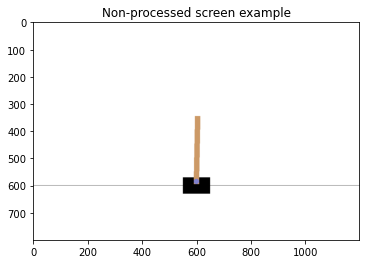

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = CartPoleEnvManager(device)
em.reset()
screen = em.render('rgb_array')

plt.figure()
plt.imshow(screen)
plt.title('Non-processed screen example')
plt.show()

<h3>Example of a processed screen</h3>

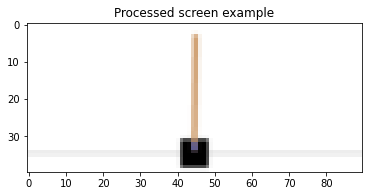

In [11]:
screen = em.get_processed_screen()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Processed screen example')
plt.show()

<h3>Example of a starting screen</h3>

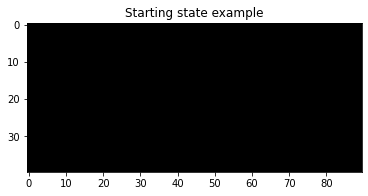

In [14]:
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Starting state example')
plt.show()

<h3>Example of a non starting screen</h3>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


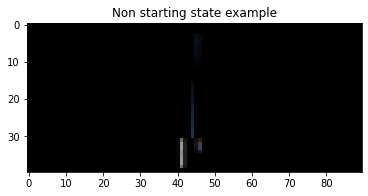

In [15]:
for i in range(5):
    em.take_action(torch.tensor([1]))
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Non starting state example')
plt.show()
#If we see most of the pic has become black because the difference between last image and current image would be moslty zero but the pixels that correspnd to card and pole show some highlight as below

<h3>Example of a End state</h3>

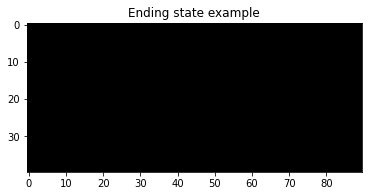

In [17]:
em.done = True
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Ending state example')
plt.show()
em.close()

<h2>Utility functions to plot etc.</h2>
<h3>Plotting</h3>

In [10]:
def plot(values, moving_avg_period): #accepts values and moving_avg_period. Used for plotting duration of each episode and 100 episode moving average
    #to solve cart and pole - the avg reward must be >= 195 over 100 consecutive episodes
    #agent gets a reward +1 for each step it takes that does not end epsode - so the duration of episode measured in time steps = reward for the episode
    plt.figure(2)
    plt.clf()        
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values) #values here are episode durations
    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)    
    plt.pause(0.001)
    print("Episode", len(values), "\n", \
        moving_avg_period, "episode moving avg:", moving_avg[-1])
    if is_ipython: display.clear_output(wait=True)
    
def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1) \
        .mean(dim=1).flatten(start_dim=0) #slices the original values tensor into 100 period tensors and calculate mean of those 100 periods and flatten them -> thats what moving average will get finally
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

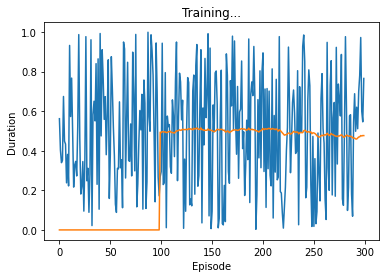

Episode 300 
 100 episode moving avg: 0.4766897


In [32]:
#Example
plot(np.random.rand(300), 100)

<h3>Main Program</h3>

<h4>HyperParameters</h4>

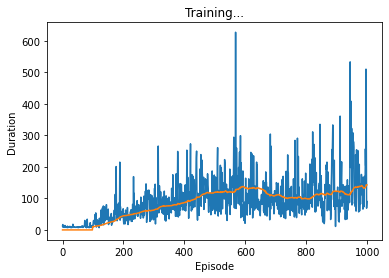

Episode 1000 
 100 episode moving avg: 142.76


In [13]:
batch_size = 256
gamma = 0.999 #discount factor for reward used in bellman eq
#starting, ending, decay rate of exploration rate - epsilon
eps_start = 1
eps_end = 0.01
eps_decay = 0.001

#this is how frequently in terms of episodes, we update the target networks weights using policy networks weights - we are using 10 here; update happens every 10 episodes [this is to avoid tail chasing head problem]
target_update = 10
memory_size = 100000 #capacity of replay memory
lr = 0.001 #learningRate
num_episodes = 1000


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


em = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)


agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)


#define policy and target networks
policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)

#set weights and biases that are in policy net to target net using PyTorch's state.dict() and load_state_dict()
target_net.load_state_dict(policy_net.state_dict())
target_net.eval() #target net is only inference, eval tells that

optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)


episode_durations = [] #We’re going to be storing our episode_durations during training in order to plot them using the plot() function we developed last time, so we create an empty list to store them in.

#follwoing below Psuedocode:
# 1.Initialize replay memory capacity.
# 2.Initialize the policy network with random weights.
# 3.Clone the policy network, and call it the target network.
# 4.For each episode:
#     1.Initialize the starting state.
#     2.For each time step:
#         1.Select an action.
#             Via exploration or exploitation
#         2.Execute selected action in an emulator.
#         3.Observe reward and next state.
#         4.Store experience in replay memory.
#         5.Sample random batch from replay memory.
#         6.Preprocess states from batch.
#         7.Pass batch of preprocessed states to policy network.
#         8.Calculate loss between output Q-values and target Q-values.
#             Requires a pass to the target network for the next state
#         9.Gradient descent updates weights in the policy network to minimize loss.
#             After  time steps, weights in the target network are updated to the weights in the policy network.

#step4
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    
    #step4.2
    for timestep in count():
        action = agent.select_action(state, policy_net) #4.2.1
        reward = em.take_action(action) #4.2.3
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward)) #4.2.4
        state = next_state
        
        #step4.2.5
        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)

            current_q_values = QValues.get_current(policy_net, states, actions) #this will be predicted q values of the state
            next_q_values = QValues.get_next(target_net, next_states) #this will be used to find max q value state action pair for the next state - used for calculating right side of bellman equation part. After calculating this can be compared with the above line current q value to optimise the policy net
            target_q_values = (next_q_values * gamma) + rewards
            
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad() #This function sets the gradients of all the weights and biases in the policy_net to zero. Since PyTorch accumulates the gradients when it does backprop, we need to call zero_grad() before backprop occurs. Otherwise, if we didn’t zero out the gradients each time, then we’d be accumulating gradients across all backprop runs.
            loss.backward() #We then call loss.backward(), which computes the gradient of the loss with respect to all the weights and biases in the policy_net.
            optimizer.step() #We now call step() on our optimizer, which updates the weights and biases with the gradients that were computed when we called backward() on our loss.
        
        if em.done:
            episode_durations.append(timestep)
            plot(episode_durations, 100)
            break
            
        if episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())

em.close()
        

<h3>Extract Tensors</h3>

In [11]:
def extract_tensors(experiences):
    # Convert batch of Experiences to Experience of batches
    batch = Experience(*zip(*experiences))

    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)

    return (t1,t2,t3,t4)


<h3>Example on Extract Tensors</h3>

In [25]:
#Example:
e1 = Experience(1,1,1,1)
e2 = Experience(2,2,2,2)
e3 = Experience(3,3,3,3)

experiences = [e1,e2,e3]
experiences

[Experience(state=1, action=1, next_state=1, reward=1),
 Experience(state=2, action=2, next_state=2, reward=2),
 Experience(state=3, action=3, next_state=3, reward=3)]

In [26]:
batch = Experience(*zip(*experiences))
batch

Experience(state=(1, 2, 3), action=(1, 2, 3), next_state=(1, 2, 3), reward=(1, 2, 3))

In [28]:
# t1 = torch.cat(batch.state)
# t2 = torch.cat(batch.action)
# t3 = torch.cat(batch.reward)
# t4 = torch.cat(batch.next_state)
#All the four above makes individula tensors for state, actiuon, reward, next state
#return (t1,t2,t3,t4) -> returns state tensor, reward tensor, action tensor and next_State tensor

<h3>QValue Calculator</h3>

In [12]:
class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    @staticmethod #these methods can be called without creating a class instance because they are static methods
    def get_current(policy_net, states, actions): #states and actions are the state action pairs sampled from replay memory
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1)) #returns predicted qvalues for specific state action pairs passed
    
    @staticmethod        
    def get_next(target_net, next_states): 
        #finding final_States locations -> as the reward obtained would be zero therafter -> therefore no pointing in sending them to target network for a prediction
        final_state_locations = next_states.flatten(start_dim=1) \
            .max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        #This leaves us with a tensor that contains zeros as the q-values associated with any final state and contains the target_net's maximum predicted q-value across all actions for each non-final state. This result is what is finally returned by get_next().
        return values
    
    #The whole point of all this code in this function was to find out if we have any final states in our next_states tensor. If we do, then we need to find out where they are so that we don’t pass them to the target_net. We don’t want to pass them to the target_net for a predicted q-value since we know that their associated q-values will be zero.